In [293]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [294]:
import csv
import plotly.offline as py
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import community
from collections import OrderedDict
import time
import requests
import seaborn as sns
import math
import numpy as np

In [337]:
%%appyter code_exec

{% do SectionField(
    name="GENES",
    title="Submit a gene list",
) %}


'''
gene_list = {{ TextField(
    name="gene_list",
    label="Gene list",
    description="Paste with a single gene on each line.",
    section="GENES",
    default="",
)}}
'''

n_genes = {{ IntField(
    name="n_genes",
    label="Minimum number of genes per cluster",
    section="GENES",
    default=20,
    minimum=2,
    maximum=1000000
)}}

gene_list_selection = '''{{ ChoiceField(
    name = "gene_list_selection",
    label="Sample gene list to load",
    section="GENES",
    default="SARS-CoV-2_down",
    choices=["SARS-CoV-2_down","ULK4_293_coIP_hits"]
)}}'''

sars_list = 5

```python
'''
gene_list = ''''''
'''
n_genes = 20
gene_list_selection = '''SARS-CoV-2_down'''
sars_list = 5
```

In [336]:
with open("SARS-CoV-2_down.gmt.txt","r") as f_in:
    writer = csv.reader(f_in, lineterminator='\n',delimiter="\t")
    sample_genes = [sublist for sublist in writer ]
    #gene_list = [ x.upper() for x in sample_genes ]
    gene_list = [ [ y for y in x[2:] if y != "" ] for x in sample_genes ] 
    print(len(gene_list))
    


17


In [340]:
# Load a sample gene list
sample_genes = []

if gene_list_selection == "ULK4_293_coIP_hits":
    with open("ULK4_293_coIP_hits.txt","r") as f_in:
        writer = csv.reader(f_in, lineterminator='\n')
        sample_genes = [item for sublist in writer for item in sublist if len(sublist) > 0]
        gene_list = [ x.upper() for x in sample_genes ]
elif gene_list_selection == "SARS-CoV-2_down":
    with open("SARS-CoV-2_down.gmt.txt","r") as f_in:
        writer = csv.reader(f_in, lineterminator='\n',delimiter="\t")
        sample_gene_lists = [sublist for sublist in writer ]
        #gene_list = [ x.upper() for x in sample_genes ]
        sample_gene_lists = [ [ y for y in x[2:] if y != "" ] for x in sample_gene_lists ] 
        gene_list = sample_gene_lists[sars_list]
        
    
        print(gene_list)       

['C1QL1', 'SNTB1', 'FAM3B', 'ALDH18A1', 'GRB7', 'ARHGEF2', 'PWWP2A', 'TINAGL1', 'TCTN3', 'BTG1', 'ACSS2', 'DOCK6', 'PAQR5', 'C1ORF115', 'DGAT2', 'VEGFA', 'PFKP', 'HPCAL1', 'LOC105375166', 'SBNO1', 'LDHA', 'TMEM176B', 'ZKSCAN1', 'CXXC5', 'WASF2', 'DSG2', 'SENP7', 'VLDLR', 'HOXA5', 'PTPN22', 'PIAS1', 'TFF2', 'EIF4A2', 'PFKFB4', 'DNM2', 'KLF11', 'TPI1', 'MLXIPL', 'GUCD1', 'WDR48', 'TOB1', 'MT-TV', 'PDK1', 'FXYD3', 'PALM3', 'DBN1', 'CA9', 'INSIG1', 'ALDOA', 'MPZL3', 'PRKAB2', 'TAOK3', 'TCN2', 'IGBP1', 'CCNG2', 'SERINC2', 'SYNPR', 'BMP2', 'ADRBK2', 'BAZ2A', 'PIM1', 'GOLGA4', 'RBPJ', 'ENO2', 'ZNF608', 'CEACAM7', 'EDN2', 'C14ORF93', 'SMPDL3A', 'ERICH2', 'APOBEC1', 'ZHX1', 'CLMN', 'FNBP1', 'ASAP1', 'RYBP', 'PPP1R3B', 'ARID4A', 'SEMA4B', 'ITPKB', 'KDM7A', 'LCN2', 'FRY', 'PLOD2', 'AQP1', 'RAB40C', 'CHD2', 'KANSL1', 'ELL2', 'AATK', 'SLC16A3', 'GNA13', 'PELI2', 'DGKA', 'USP53', 'TGOLN2', 'HERC3', 'HSPB1', 'CEP72', 'SLC11A2', 'PAG1', 'PTPRR', 'SAT1', 'PCED1B', 'SH3BP2', 'NEAT1', 'ELF3', 'CYP3A5', '

In [319]:
# Load data
cloud_url = 'https://appyters.maayanlab.cloud/storage/Gene_Network_Analysis/'
#cloud_url = "" # for reading locally

df_ppi_edges = pd.read_csv(cloud_url + 'ppi_edges_list.csv',header=None)
#df_gene_edges = pd.read_csv(cloud_url + 'gene_edges_list.csv')
df_gene_edges = pd.read_csv(cloud_url + 'top_10_correlation.csv')


display(df_ppi_edges.head())
print(df_ppi_edges.shape)
display(df_gene_edges.head())
print(df_gene_edges.shape)



,0,1
0,S100A8,LGALS7B
1,S100A8,IGSF21
2,S100A8,IVL
3,S100A8,SERPINB3
4,S100A8,NCF2


(282532, 2)


,A1BG,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,ITIH1,PAH,ITIH2,PPL,ARRDC5,ALPPL2,METTL7B,SNRPA,SLC35E3,TP53I13,...,CSE1L,MCM6,YBX1P4,CPS1,NSA2,CA5A,PPP1R3A,GNAI2,GAREM1,MAP2K6
1,AGXT,SLC2A2,AHSG,TGM1,RP11.927P21.9,KLRG2,SSTR5,RUVBL2,PEX26,RENBP,...,NPM1,TIMELESS,RP11.475I24.1,CKAP2P1,CICP27,FAM98C,TXLNB,TGFB1,DHRS12,HSBP1
2,CYP4A11,CPB2,IGFBP1,KLK13,CSPG4P11,FGF4,C2ORF82,PLK1,ZNF793,PRRT4,...,RAN,SAA3P,REM2,GLP2R,RPL10AP5,PCDHB1,TRDN,PXN,ATP5LP3,POT1
3,C8B,APOH,ITIH3,SCEL,SMIM2,NLRP7,KLHL4,CDC20,RPS6KA5,PPOX,...,LDHB,PSMC5,RP5.1147A1.1,RP11.91J3.1,RPL21P3,USHBP1,XIRP2,VASP,GPR162,SNRPGP14
4,SLC25A47,ALB,AGT,KRT78,RP11.123K3.4,DNMT3L,SPIC,KIF22,ZNF556,AQP7P1,...,PAICS,RFC3,SMCR8,MTNR1A,RPL37P1,ZBTB8B,PYGM,SPI1,RPL27A,GOLGA2P2Y


(10, 26415)


In [341]:
ppi_edges_dict = {}

for index, row in df_ppi_edges.iterrows():
    if row[0] in ppi_edges_dict:
        ppi_edges_dict[row[0]].append(row[1])
    else:
        ppi_edges_dict[row[0]] = [row[1]]
        

gene_edges_dict = df_gene_edges.to_dict('list')

In [342]:

'''
def get_relevant_ppi_edges(gene_list):
    edges = []
    for gene in gene_list:
        if gene in ppi_edges_dict:  
            edges = [*edges,  *[(gene, x) for x in ppi_edges_dict[gene]]]
    return edges

def get_relevant_gene_edges(gene_list):
    edges = []
    for gene in gene_list:
        if gene in gene_edges_dict:  
            edges = [*edges,  *[(gene, x) for x in gene_edges_dict[gene]]]
    return edges
'''

def get_relevant_ppi_edges(gene_list):
    edges = []
    missing = []
    for gene_a in gene_list:
        if gene_a in ppi_edges_dict:
            for gene_b in ppi_edges_dict[gene_a]:
                if gene_b in gene_list: edges.append((gene_a, gene_b))      
        else: missing.append(gene_a)
    return edges,missing

def get_relevant_gene_edges(gene_list):
    edges = []
    missing = []
    for gene_a in gene_list:
        if gene_a in gene_edges_dict:
            for gene_b in gene_edges_dict[gene_a]:
                if gene_b in gene_list: edges.append((gene_a, gene_b))
        else: missing.append(gene_a)
    return edges,missing

In [343]:
# create the Network object
ppi_edges,ppi_missing = get_relevant_ppi_edges(gene_list)
gene_edges,gene_missing = get_relevant_gene_edges(gene_list)

def create_network(gene_list,ppi_edges,gene_edges):
    G = nx.Graph()
    G.add_nodes_from(gene_list)
    #G.add_edges_from(ppi_edges)
    G.add_edges_from(gene_edges)
    return G

G = create_network(gene_list,ppi_edges,gene_edges)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 274
Average degree:   1.0960


In [344]:
print(ppi_missing)

#print("\n".join(ppi_missing))

['C1QL1', 'C1ORF115', 'LOC105375166', 'SBNO1', 'TMEM176B', 'MT-TV', 'PALM3', 'TCN2', 'CEACAM7', 'C14ORF93', 'ERICH2', 'CLMN', 'KDM7A', 'PCED1B', 'NEAT1', 'UCA1', 'PSCA', 'FAM114A1', 'C17ORF78', 'ZFHX2', 'TMEM141', 'CRAT', 'ESRG', 'MEX3A', 'NDNF', 'SLC27A1', 'LOC101927009', 'MALAT1', 'SMIM24', 'C4ORF3', 'PNCK', 'IFITM10', 'SLC5A3', 'TMEM176A', 'MUC17', 'NYNRIN', 'KRT12', 'OLMALINC', 'PRR36', 'ACSL5', 'FAM213A', 'CCDC18-AS1', 'MIR210HG', 'FXYD5', 'XPNPEP2', 'RAP1GAP2', 'PAXIP1-AS1', 'RETNLB', 'HHLA2', 'TMEM91', 'KHNYN', 'LINC01559', 'HLA-F-AS1', 'SLC25A23', 'DNAH1', 'DNHD1', 'SNHG7', 'NPSR1-AS1', 'SLC6A6', 'AOAH', 'LEMD1', 'AOC1', 'TMEM256', 'KIAA1109', 'TPPP3', 'LOC100131257', 'GPA33', 'AMN', 'EPB41L4A-AS1', 'GATA6-AS1', 'UNC93A', 'COLCA2', 'TMEM255B', 'GPR146', 'SMOC2', 'SLC16A4', 'ZC3H6', 'BRWD3', 'LOC100506548', 'FER1L4', 'DHRS3', 'TMCC1', 'CAPN12', 'SMIM3', 'TMC4', 'ANKIB1', 'CA11', 'KCNQ1OT1', 'SLCO4A1', 'TMEM94']


In [345]:
print(gene_missing)

['LOC105375166', 'MT-TV', 'ADRBK2', 'NEAT1', 'UCA1', 'ESRG', 'LOC101927009', 'MALAT1', 'OLMALINC', 'CCDC18-AS1', 'MIR210HG', 'PAXIP1-AS1', 'LINC01559', 'HLA-F-AS1', 'SNHG7', 'NPSR1-AS1', 'LOC554223', 'HLA-A', 'LOC100131257', 'EPB41L4A-AS1', 'GATA6-AS1', 'LOC100506548', 'HLA-G', 'ADRBK1', 'MT-RNR2', 'KCNQ1OT1']


In [346]:
print(set(ppi_missing).intersection(set(gene_missing)))

{'MALAT1', 'LOC101927009', 'EPB41L4A-AS1', 'OLMALINC', 'LOC100131257', 'ESRG', 'LOC105375166', 'GATA6-AS1', 'UCA1', 'LOC100506548', 'CCDC18-AS1', 'MIR210HG', 'MT-TV', 'LINC01559', 'KCNQ1OT1', 'NPSR1-AS1', 'NEAT1', 'HLA-F-AS1', 'SNHG7', 'PAXIP1-AS1'}


In [347]:
# Clustering
all_clusters = {}

In [348]:
# k_clique_communities
c = list(community.k_clique_communities(G, 2)) 
clusters = [ list(x) for x in c if len(x) > n_genes]
print(len(clusters))
all_clusters["k_clique_communities"] = clusters

print(clusters)
print(len(all_clusters["k_clique_communities"][0]))

2
[['HK2', 'TFF2', 'SMURF1', 'KDM5C', 'FCGRT', 'MAP3K2', 'ACTN1', 'SLC2A1', 'DNM2', 'GAL3ST1', 'ADM', 'PLOD2', 'ANGPTL4', 'KIAA1109', 'P4HA1', 'APP', 'MKNK2', 'NBR1', 'ALDOA', 'INSIG2', 'TGOLN2', 'MYH9', 'BTG1', 'CXCR4', 'P2RX4', 'CD46', 'PLIN2', 'PGK1', 'KDM7A', 'GUCD1', 'KHNYN', 'CD68', 'KDM4B', 'LDHA', 'TPI1', 'BNIP3', 'KDM3A', 'CXXC5', 'TCN2', 'IFITM10', 'PSAP', 'YPEL2', 'HILPDA', 'PFKP', 'VEGFA', 'PFKFB3', 'EGLN3', 'NDRG1', 'GDI1', 'FRY', 'CAST', 'CA9', 'GAA', 'CHD2', 'EIF4B', 'CCNI', 'CREBRF', 'PRR36', 'DSP', 'GRN', 'KLHL24', 'AHNAK', 'CLK1', 'TSC22D3', 'ENO2', 'ANKRD37', 'SORL1', 'SLC16A3', 'RBCK1', 'DDIT4', 'ZNF395', 'EEF2', 'BAZ2A', 'DENND4C'], ['AOC1', 'C17ORF78', 'CLDN15', 'TMEM141', 'EPCAM', 'CEACAM7', 'SMPDL3A', 'CEACAM5', 'MTMR11', 'C1ORF115', 'SLC39A4', 'ACSL5', 'FCGBP', 'SUCLG2', 'APOBEC1', 'ETS2', 'DSG2', 'SPINT1', 'CEACAM1', 'GPA33', 'PCK1', 'SMPD3', 'PIGR', 'XPNPEP2', 'SPINT2', 'RETNLB', 'PRAP1', 'CDHR5', 'SLC22A18', 'ANO9', 'RNF186', 'ANKRD9', 'HHLA2', 'FAM3B', 'MOG

In [349]:
# Girvan newman communities
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
# next_level_communities = next(communities_generator)

clusters = [ x for x in sorted(map(sorted, top_level_communities)) if len(x) > n_genes ]
print(len(clusters))
all_clusters["girvan_newman"] = clusters

print(clusters)

3
[['ACSL5', 'AMN', 'ANKRD9', 'ANO9', 'AOC1', 'APOBEC1', 'C17ORF78', 'C1ORF115', 'CDHR5', 'CEACAM1', 'CEACAM5', 'CEACAM7', 'CLDN15', 'DSG2', 'EPCAM', 'ETS2', 'FAM3B', 'FCGBP', 'GPA33', 'HHLA2', 'MOGAT2', 'MTMR11', 'PCK1', 'PIGR', 'PRAP1', 'PRSS8', 'RETNLB', 'RNF186', 'SLC22A18', 'SLC39A4', 'SMIM24', 'SMPD3', 'SMPDL3A', 'SPINT1', 'SPINT2', 'SUCLG2', 'TMEM120A', 'TMEM141', 'XPNPEP2'], ['ACTN1', 'AHNAK', 'BAZ2A', 'CAST', 'CD46', 'CHD2', 'DENND4C', 'DNM2', 'EEF2', 'EIF4B', 'FRY', 'GUCD1', 'KDM3A', 'KDM4B', 'KDM5C', 'KDM7A', 'KHNYN', 'KIAA1109', 'KLHL24', 'MAP3K2', 'MKNK2', 'MYH9', 'NBR1', 'PFKP', 'RBCK1', 'SMURF1', 'SORL1', 'TFF2', 'TGOLN2', 'YPEL2'], ['ADM', 'ALDOA', 'ANGPTL4', 'ANKRD37', 'APP', 'BNIP3', 'BTG1', 'CA9', 'CCNI', 'CD68', 'CLK1', 'CREBRF', 'CXCR4', 'CXXC5', 'DDIT4', 'DSP', 'EGLN3', 'ENO2', 'FCGRT', 'GAA', 'GAL3ST1', 'GDI1', 'GRN', 'HILPDA', 'HK2', 'IFITM10', 'INSIG2', 'LDHA', 'NDRG1', 'P2RX4', 'P4HA1', 'PFKFB3', 'PGK1', 'PLIN2', 'PLOD2', 'PRR36', 'PSAP', 'SLC16A3', 'SLC2A1', 

In [350]:
# greedy_modularity_communities
c = list(community.greedy_modularity_communities(G))
clusters = [ list(x) for x in c if len(x) > n_genes]
all_clusters["greedy_modularity_communities"] = clusters
print(len(clusters))

print(clusters)

2
[['HK2', 'GAL3ST1', 'SLC2A1', 'ANGPTL4', 'ADM', 'PLOD2', 'P4HA1', 'ALDOA', 'INSIG2', 'APP', 'PLIN2', 'PGK1', 'LDHA', 'TPI1', 'BNIP3', 'CXXC5', 'HILPDA', 'VEGFA', 'NDRG1', 'GDI1', 'PFKFB3', 'EGLN3', 'CA9', 'CCNI', 'PRR36', 'DSP', 'ENO2', 'ANKRD37', 'DDIT4', 'ZNF395'], ['C17ORF78', 'AOC1', 'CLDN15', 'SMPDL3A', 'C1ORF115', 'SLC39A4', 'ACSL5', 'APOBEC1', 'ETS2', 'PCK1', 'SMPD3', 'XPNPEP2', 'PRAP1', 'CDHR5', 'SLC22A18', 'ANO9', 'ANKRD9', 'HHLA2', 'FAM3B', 'MOGAT2', 'TMEM120A', 'SMIM24', 'AMN']]


In [351]:
# connected_components
components = sorted(nx.connected_components(G), key = len, reverse=True)
clusters = [ list(x) for x in components if len(x) > n_genes ]
print(len(clusters))
all_clusters["connected_components"] = clusters

print("\n".join(clusters[0]))

2
HK2
MAP3K2
SMURF1
FCGRT
KDM5C
TFF2
SLC2A1
GAL3ST1
ANGPTL4
ADM
ACTN1
PLOD2
DNM2
KIAA1109
P4HA1
MKNK2
NBR1
ALDOA
INSIG2
TGOLN2
MYH9
BTG1
CXCR4
APP
P2RX4
PLIN2
PGK1
CD46
GUCD1
CD68
KHNYN
KDM4B
KDM7A
LDHA
TPI1
BNIP3
KDM3A
CXXC5
TCN2
IFITM10
PSAP
HILPDA
YPEL2
VEGFA
NDRG1
PFKFB3
GDI1
EGLN3
PFKP
FRY
CAST
CA9
GAA
CHD2
CCNI
PRR36
CREBRF
DSP
EIF4B
GRN
KLHL24
AHNAK
CLK1
TSC22D3
ENO2
ANKRD37
SORL1
SLC16A3
RBCK1
DDIT4
ZNF395
EEF2
BAZ2A
DENND4C


In [353]:
# Validation with Enrichr
enrichr_libraries = OrderedDict([
    ('Ontologies', ['GO_Biological_Process_2018']),
])

# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])


In [354]:
# Get Enrichr links for each cluster
enrichr_links = {}

for clustering_method, clusters in all_clusters.items():
    enrichr_links[clustering_method] = {}
    for index, genes in enumerate(clusters):
        try:
            link = enrichr_link_from_genes(genes, f'{clustering_method} cluster {index}')
        except:
            link = None
            print(f'Enrichr failed for {clustering_method}, cluster {index} genes')

        enrichr_links[clustering_method][index] = link

In [355]:
top_n_results = 5
num_overall_results = 500
sort_by = 'combinedscore'

# Grab top results for each cluster
all_enrichr_results = []

for clustering_method, links in enrichr_links.items():
    if clustering_method == 'overall': continue
    num_clusters = len(all_clusters[clustering_method])
    top_n_results = int(num_overall_results / num_clusters)
    print(top_n_results)
    for cluster, link in links.items():
        if link is None:
            continue
        for category, libraries in enrichr_libraries.items():
            for library in libraries:
                try:
                    results = enrichr_get_top_results(link['userListId'], library).sort_values(sort_by).iloc[:top_n_results]
                    results['clustering_method'] = clustering_method
                    results['link'] = link['link']
                    results['library'] = library
                    results['category'] = category
                    results['cluster'] = cluster
                    all_enrichr_results.append(results)
                except:
                    print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, clustering_method, cluster))

df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

250
166
250
250


In [356]:
display(df_enrichr_results)

,index,rank,term,pvalue,zscore,combinedscore,overlapping_genes,adjusted_pvalue,,,clustering_method,link,library,category,cluster
0,846,847,negative regulation of cellular macromolecule ...,0.853776,0.527872,0.083449,[KDM5C],1.0,0,0,k_clique_communities,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
1,845,846,nervous system development (GO:0007399),0.818426,0.594001,0.119021,[VEGFA],1.0,0,0,k_clique_communities,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
2,844,845,negative regulation of nucleic acid-templated ...,0.810691,0.608717,0.127750,[KDM5C],1.0,0,0,k_clique_communities,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
3,843,844,"transcription, DNA-templated (GO:0006351)",0.735923,0.759186,0.232789,[BAZ2A],1.0,0,0,k_clique_communities,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
4,842,843,cellular protein localization (GO:0034613),0.705403,0.826515,0.288442,[SMURF1],1.0,0,0,k_clique_communities,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,9,10,heterocycle catabolic process (GO:0046700),0.011644,85.470085,380.591956,[AOC1],1.0,0,0,connected_components,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,1
1858,15,16,bundle of His cell-Purkinje myocyte adhesion i...,0.011644,85.470085,380.591956,[DSG2],1.0,0,0,connected_components,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,1
1859,13,14,response to heparin (GO:0071503),0.011644,85.470085,380.591956,[AOC1],1.0,0,0,connected_components,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,1
1860,11,12,regulation of blood vessel remodeling (GO:0060...,0.011644,85.470085,380.591956,[CEACAM1],1.0,0,0,connected_components,https://amp.pharm.mssm.edu/Enrichr/enrich?data...,GO_Biological_Process_2018,Ontologies,1


In [357]:
unique_terms = {}
num_unique_terms = []

num_unique_hits = []

for clustering_method in [ x for x in df_enrichr_results["clustering_method"].unique() if x != "overall"]:
    df_method = df_enrichr_results.loc[df_enrichr_results["clustering_method"] == clustering_method]
    
    terms = df_method["term"].values    
    unique = list(set(terms))
    num_unique_terms.append(len(unique))
    unique_terms[clustering_method] = unique
    
    hits = df_method.shape[0]
    num_unique_hits.append(hits)



# avg number of unique terms per method
avg_unique_terms = int(np.mean(np.array(num_unique_terms)))
print("Average unique terms per clustering method: ", avg_unique_terms)

# avg number of enrichr entries per method
avg_hits = int(np.mean(np.array(num_unique_hits)))
print("Average hits per clustering method: ", avg_hits)

Average unique terms per clustering method:  409
Average hits per clustering method:  465


In [358]:
# get data on the overall gene set 

try:
    link = enrichr_link_from_genes(gene_list, 'overall')
    results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:avg_hits]
    results['clustering_method'] = 'overall'
    results['link'] = link['link']
    results['library'] = library
    results['category'] = category
    results['cluster'] = cluster
    all_enrichr_results.append(results)
except:
    print('Failed to get Enrichr results for overall gene set')


df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

In [359]:
neg_log_pvalues = {}
combined_scores = {}

for clustering_method in df_enrichr_results["clustering_method"].unique():
    df_method = df_enrichr_results.loc[df_enrichr_results["clustering_method"] == clustering_method]

    vals = df_method["pvalue"].values
    neg_log_pvalues[clustering_method] = [ -math.log(p) for p in vals]
    
    combined_scores[clustering_method] = df_method["combinedscore"].values

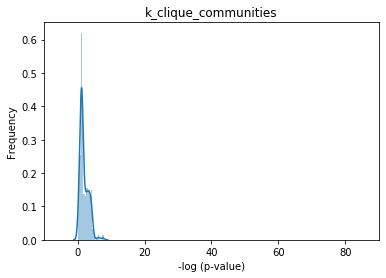

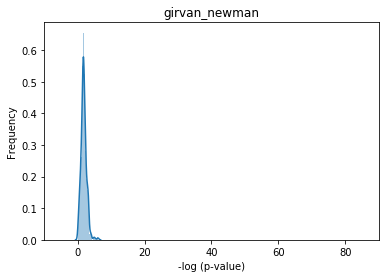

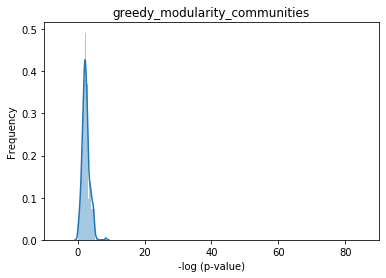

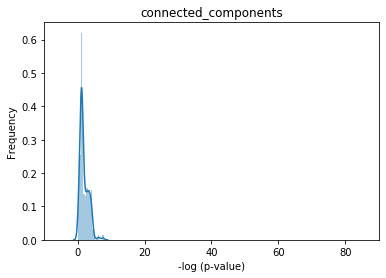

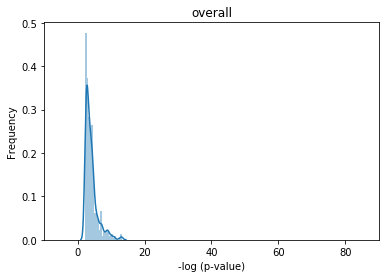

In [360]:
# plot one distribution per method

for clustering_method, y in neg_log_pvalues.items():
    fig, ax = plt.subplots()
    sns.distplot(y, ax=ax, label=clustering_method)
    ax.set_title(clustering_method)
    ax.set_xlabel("-log (p-value)")
    ax.set_ylabel("Frequency")
    plt.xlim([-10,90])
    

495
498
374
495
465


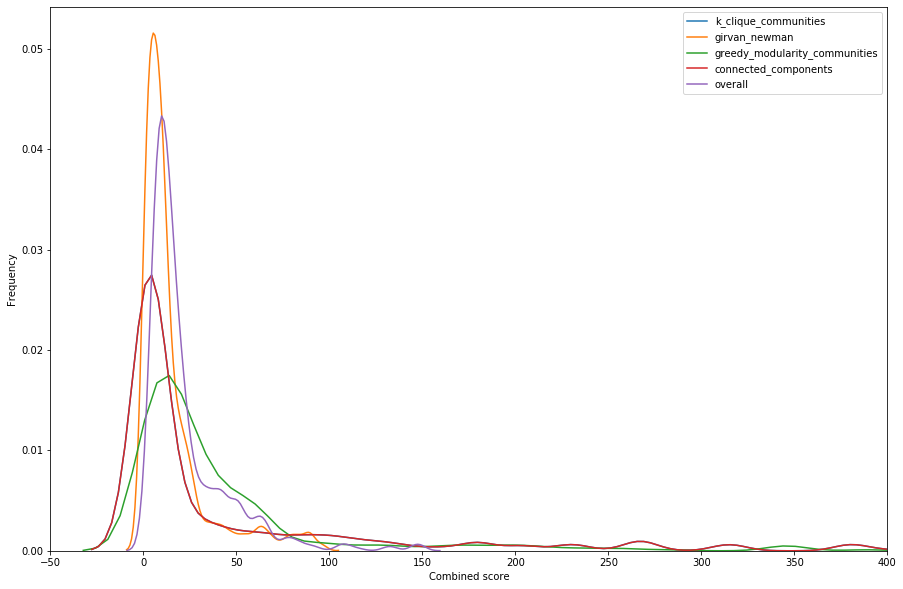

In [361]:
# Overlay the kernel density estimates of combined scores on a single plot

fig, ax = plt.subplots(figsize=(15,10))


for clustering_method, y in combined_scores.items():
    print(len(y))
    sns.distplot(y, ax=ax, label=clustering_method, hist=False)
    #ax.set_title(clustering_method)
ax.set_xlabel("Combined score")
ax.set_ylabel("Frequency")
ax.set_xlim([-50,400])
ax.legend()


In [375]:
df_clusters = pd.DataFrame(index=gene_list, columns=[ x for x in df_enrichr_results["clustering_method"].unique() if x!="overall"])

for clustering_method, clusters in all_clusters.items():
    for index,cluster in enumerate(clusters):
        for gene in cluster:
            df_clusters.loc[gene,clustering_method] = index

display(df_clusters.head())

         

,k_clique_communities,girvan_newman,greedy_modularity_communities,connected_components
C1QL1,NaN,NaN,NaN,NaN
SNTB1,NaN,NaN,NaN,NaN
FAM3B,1,0,1,1
ALDH18A1,NaN,NaN,NaN,NaN
GRB7,NaN,NaN,NaN,NaN


In [362]:
from pyvis.network import Network

nt = Network(width="100%", height = "1000px", notebook=True)
nt.from_nx(G)
nt.show("graph.html")